In [1]:
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import random_split, DataLoader
from torchvision.models import vgg19
import tqdm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from brisque import BRISQUE
from dataset import EXRDataset
import torch.nn.functional as F

In [2]:
# enable using OpenEXR with OpenCV
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = "1"

FILE_PATH = os.path.normpath("./data/reference/001.exr")

def read_exr(im_path: str) -> np.ndarray:
    return cv2.imread(
    filename=im_path,
    flags=cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH
    )
def tone_map_reinhard(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapReinhard(
    gamma=2.2,
    intensity=0.0,
    light_adapt=0.0,
    color_adapt=0.0
    )
    result = tonemap_operator.process(src=image)
    return result
def tone_map_mantiuk(image: np.ndarray) -> np.ndarray:
    tonemap_operator = cv2.createTonemapMantiuk(
    gamma=2.2,
    scale=0.85,
    saturation=1.2
    )
    result = tonemap_operator.process(src=image)
    return result

def evaluate_image(image: np.ndarray) -> float:
    metric = BRISQUE(url=False)
    return metric.score(img=image)

def fix_colors(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def clip(img):
    return np.clip(img / np.max(img), 0, 1)

In [3]:
# image = read_exr(im_path=FILE_PATH)
# tone_mapped_reinhard = tone_map_reinhard(image)
# tone_mapped_mantiuk = tone_map_mantiuk(image)

# fig, axes = plt.subplots(1, 3, figsize=(10, 5)) 

# axes[0].imshow(fix_colors(clip(image)))
# axes[0].axis('off')
# axes[0].set_title("original")

# axes[1].imshow(fix_colors(tone_mapped_reinhard))
# axes[1].axis('off')
# axes[1].set_title("tone_mapped_reinhard")

# axes[2].imshow(fix_colors(tone_mapped_mantiuk))
# axes[2].axis('off')
# axes[2].set_title("tone_mapped_mantiuk")

# print('tone_mapped_reinhard', evaluate_image(image=tone_mapped_reinhard))
# print('tone_mapped_mantiuk', evaluate_image(image=tone_mapped_mantiuk))

# 3.1 Multiple Exposure Selection

In [22]:
def aces_estimation(t=0.85, A=2.51, B=0.03, C=2.43, D=0.59, E=0.14):
    # (tC - A)x^2 + (tD - B)x + tE = 0
    a = t * C - A
    b = t * D - B
    c = t * E

    delta = b ** 2 - 4 * a * c
    root1 = (-b - np.sqrt(delta)) / (2 * a)
    root2 = (-b + np.sqrt(delta)) / (2 * a)
    return root1 if root1 > 0 else root2

def exposures(img: torch.Tensor):
    x_p = aces_estimation()

    c_start = torch.log(x_p / torch.max(img))

    percentile_50 = torch.quantile(img, 0.5)
    c_end = torch.log2(x_p / percentile_50)

    output_list = []
    exp_value = [c_start, (c_end + c_start) / 2.0, c_end]
    for value in exp_value:
        sc = torch.pow(torch.sqrt(torch.tensor(2.0)), value)
        img_exp = img * sc
        img_out = torch.clip(img_exp, 0, 1)
        output_list.append(img_out)

    return output_list

In [5]:
# def normalize(img):
#     return img * (0.5 / np.mean(img))

# img_low, img_mid, img_high = exposures(torch.from_numpy(normalize(image)))

# fig, axes = plt.subplots(1, 4, figsize=(10, 10)) 

# axes[0].imshow(fix_colors(normalize(image)))
# axes[0].axis('off')
# axes[0].set_title("I-src")


# axes[1].imshow(fix_colors(img_low.detach().cpu().numpy()))
# axes[1].axis('off')
# axes[1].set_title("I-e-low")

# axes[2].imshow(fix_colors(img_mid.detach().cpu().numpy()))
# axes[2].axis('off')
# axes[2].set_title("I-e-mid")

# axes[3].imshow(fix_colors(img_high.detach().cpu().numpy()))
# axes[3].axis('off')
# axes[3].set_title("I-e-high")

# 3.2 Tone Mapping Network

In [23]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Conv2d(192, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, exp1, exp2, exp3):
        x = self.decoder(x)
        residual = x + exp1 + exp2 + exp3
        return self.sigmoid(residual)
    

class SelfTMO(nn.Module):
    def __init__(self):
        super(SelfTMO, self).__init__()

        # 1 instance of encoder to share the weights
        self.encoder = Encoder()
        
        self.fusion = nn.Sequential(
            nn.Conv2d(192, 192, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(192, 192, kernel_size=1, stride=1)
        )

        self.decoder = Decoder()

    def forward(self, exp1, exp2, exp3):
        exp1_enc = self.encoder(exp1)
        exp2_enc = self.encoder(exp2)
        exp3_enc = self.encoder(exp3)

        concat = torch.concat([exp1_enc, exp2_enc, exp3_enc], axis = 1)
        
        concat = self.fusion(concat)
        concat = self.decoder(concat, exp1, exp2, exp3)

        return concat

# 3.3 Adaptive μ-law compression

In [24]:
def mi_law(input, lambda1=8.759, lambda2=0.1494, gamma1=2.148, gamma2=-2.067):
    return lambda1 * (input ** gamma1) + lambda2 * (input ** gamma2)

def mi_img(img: np.ndarray):
    law_value = mi_law(img)
    return torch.log(1+law_value*img)/torch.log(1+law_value)

# 3.4 Feature Contrast Masking Loss

# Training

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(device)

cuda


In [96]:
model_vgg19 = vgg19(pretrained=True).features[:18].to(device)
model_vgg19.eval()

def feature_contrast(feature_map, patch_size=13, epsilon=1e-4):
    kernel = torch.ones(feature_map.shape[1], 1, patch_size, patch_size, device=feature_map.device) / (patch_size ** 2)
    
    gauss = F.conv2d(feature_map, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    return (feature_map - gauss) / (torch.abs(gauss) + epsilon)


def feature_contrast_self_masking(feature_map, alpha, patch_size=13):  # mi: alpha=0.5, TM: alpha=1
    C = feature_contrast(feature_map, patch_size=patch_size)
    return torch.sign(C)*torch.abs(C)**alpha


def feature_contrast_neighborhood_masking(feature_map, patch_size=13, epsilon=1e-4):
    kernel = torch.ones((feature_map.shape[1], 1, patch_size, patch_size), dtype=torch.float32, device=feature_map.device) / (patch_size ** 2)
    
    mi_b = F.conv2d(feature_map, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    feature_map_squared = feature_map ** 2
    mi_b_squared = F.conv2d(feature_map_squared, kernel, padding=patch_size//2, groups=feature_map.shape[1])
    
    sigma_b = torch.sqrt(mi_b_squared - mi_b ** 2 + epsilon)
    
    contrast_map = sigma_b / (torch.abs(mi_b) + epsilon)
    
    return contrast_map.squeeze(0)

    
def f(Ms, Mn):
    return Ms / (1+Mn)

def loss(I_mi, I_tm):
    mi_vgg = model_vgg19(I_mi)
    tm_vgg = model_vgg19(I_tm)
    return torch.mean(torch.abs(
        f(feature_contrast_self_masking(mi_vgg, 0.5, patch_size=11), feature_contrast_neighborhood_masking(mi_vgg, patch_size=11)) - 
        f(feature_contrast_self_masking(tm_vgg, 1, patch_size=11), feature_contrast_neighborhood_masking(tm_vgg, patch_size=11))
    ))

/home/dominik/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dominik/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [95]:
model = SelfTMO()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

losses = {"train":[],"val":[]}

In [42]:
dataset = EXRDataset("./data/processed")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

In [97]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    for img in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        img = img.to(device)

        img_low, img_mid, img_high = exposures(img)

        I_tm = model(img_low, img_mid, img_high)
        I_mi = mi_img(img)

        a = loss(I_mi, I_tm)

        a.backward()
        optimizer.step()
    
    model.eval()
    print(f"epoch #{epoch+1}, loss: {a}")
    losses["train"].append(a.item())
    with torch.no_grad():
        total_loss = 0.0
        for img in val_dataset:
            img = img.unsqueeze(0).to(device)
            img_low, img_mid, img_high = exposures(img)
            I_tm = model(img_low, img_mid, img_high)

            I_mi = mi_img(img)

            a = loss(I_mi, I_tm)
            total_loss += a.item()
        print("Validation loss:",total_loss / len(val_dataset))
    losses["val"].append(total_loss)

    if (epoch + 1) % 10 == 0:
        scheduler.step()

100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #1, loss: 0.17930567264556885
Validation loss: 0.19844119572961652


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #2, loss: 0.17318812012672424
Validation loss: 0.18434366422730522


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #3, loss: 0.18034814298152924
Validation loss: 0.17747496894082507


100%|██████████| 36/36 [00:45<00:00,  1.26s/it]


epoch #4, loss: 0.1678411066532135
Validation loss: 0.17752416331220316


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #5, loss: 0.14551758766174316
Validation loss: 0.16186346456005768


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #6, loss: 0.18183806538581848
Validation loss: 0.16118680001110644


100%|██████████| 36/36 [00:46<00:00,  1.29s/it]


epoch #7, loss: 0.1550339013338089
Validation loss: 0.16275432967656367


100%|██████████| 36/36 [00:45<00:00,  1.26s/it]


epoch #8, loss: 0.13341927528381348
Validation loss: 0.14938773939738403


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #9, loss: 0.16033200919628143
Validation loss: 0.15513520446178075


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #10, loss: 0.13570666313171387
Validation loss: 0.1529807448387146


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #11, loss: 0.10258898138999939
Validation loss: 0.14603735063527082


100%|██████████| 36/36 [00:45<00:00,  1.26s/it]


epoch #12, loss: 0.12586817145347595
Validation loss: 0.14182686785588394


100%|██████████| 36/36 [00:46<00:00,  1.28s/it]


epoch #13, loss: 0.11959583312273026
Validation loss: 0.14268880418023547


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #14, loss: 0.12191425263881683
Validation loss: 0.1501483137945871


100%|██████████| 36/36 [00:45<00:00,  1.25s/it]


epoch #15, loss: 0.12206712365150452
Validation loss: 0.14307988857900775


100%|██████████| 36/36 [00:45<00:00,  1.27s/it]


epoch #16, loss: 0.1169796958565712
Validation loss: 0.1414394376648439


100%|██████████| 36/36 [00:45<00:00,  1.25s/it]


epoch #17, loss: 0.11085356771945953
Validation loss: 0.14720497924733805


100%|██████████| 36/36 [00:45<00:00,  1.28s/it]


epoch #18, loss: 0.15038898587226868
Validation loss: 0.14308115437224106


100%|██████████| 36/36 [00:45<00:00,  1.28s/it]


epoch #19, loss: 0.11281728744506836
Validation loss: 0.14628713779352806


100%|██████████| 36/36 [00:47<00:00,  1.31s/it]


epoch #20, loss: 0.11614736914634705
Validation loss: 0.14806163351278048


In [53]:
import random

def lum(img):
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    l = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return l

def color_correction(img_in, img_out, s=0.6):
    l_in = lum(img_in)
    l_out = lum(img_out)

    l_in = l_in[..., np.newaxis]
    l_out = l_out[..., np.newaxis]

    return l_out * (img_in / l_in) ** s

In [100]:
torch.save(model, 'patch_size11_20.pth')
# torch.load('100epochs.pth', weights_only=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.022460202..2.7783654].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03373449..1.7787914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.013388917..3.2481093].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03242755..2.934683].


     Image  Tone Mapped Reinhard  Tone Mapped Mantiuk      Model
0  Image 0             20.668392           110.045391  31.820070
1  Image 1             40.410526            63.564879  25.577119
2  Image 2             81.228188           100.804080  85.453435
3  Image 3             25.447700            88.349389  50.252957


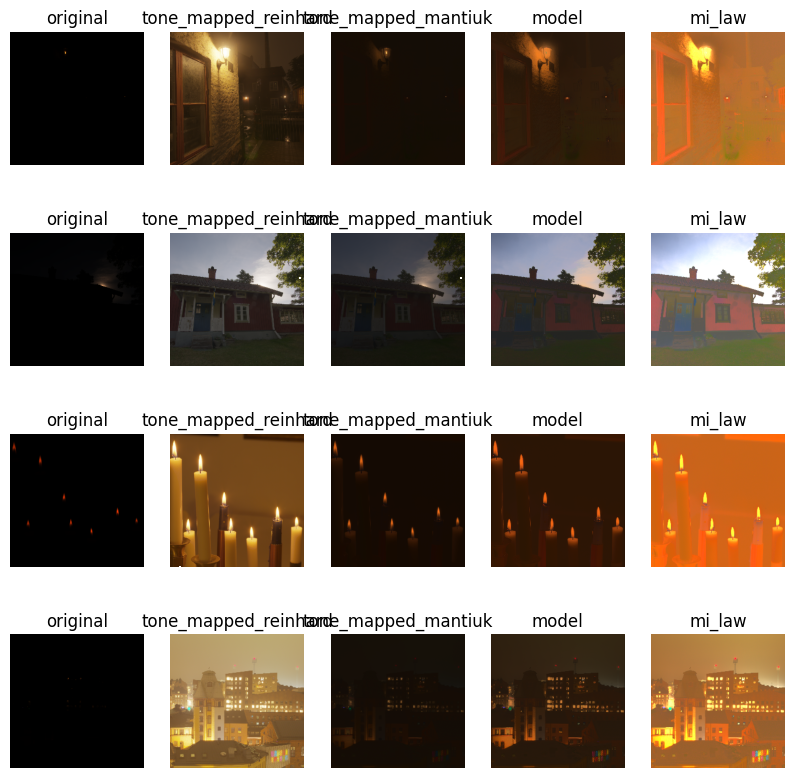

In [102]:
model.eval()

fig, axes = plt.subplots(4, 5, figsize=(10, 10))
results = []

for i in range(4):
    image1 = random.choice(val_dataset)
    image_org = clip(image1.numpy().transpose(1, 2, 0))
    image = image1.unsqueeze(0).to(device)

    img_low, img_mid, img_high = exposures(image)
    result = model(img_low, img_mid, img_high).squeeze(0)
    result = result.cpu().detach().numpy().transpose(1, 2, 0)

    tone_mapped_reinhard = tone_map_reinhard(image_org)
    tone_mapped_mantiuk = tone_map_mantiuk(image_org)
    result_corrected = clip(color_correction(image_org, result))

    axes[i, 0].imshow(fix_colors(image_org))
    axes[i, 0].axis('off')
    axes[i, 0].set_title("original")

    axes[i, 1].imshow(fix_colors(tone_mapped_reinhard))
    axes[i, 1].axis('off')
    axes[i, 1].set_title("tone_mapped_reinhard")

    axes[i, 2].imshow(fix_colors(tone_mapped_mantiuk))
    axes[i, 2].axis('off')
    axes[i, 2].set_title("tone_mapped_mantiuk")

    axes[i, 3].imshow(fix_colors(result_corrected))
    axes[i, 3].axis('off')
    axes[i, 3].set_title("model")

    axes[i, 4].imshow(fix_colors(color_correction(image_org, mi_img(image1).numpy().transpose(1, 2, 0))))
    axes[i, 4].axis('off')
    axes[i, 4].set_title("mi_law")

    eval_reinhard = evaluate_image(image=tone_mapped_reinhard)
    eval_mantiuk = evaluate_image(image=tone_mapped_mantiuk)
    eval_model = evaluate_image(image=result_corrected)

    results.append({
        'Image': f'Image {i}',
        'Tone Mapped Reinhard': eval_reinhard,
        'Tone Mapped Mantiuk': eval_mantiuk,
        'Model': eval_model
    })

print(pd.DataFrame(results))

In [99]:
model.eval()

brisques = []

for img in val_dataset:
    image = img.unsqueeze(0).to(device)

    img_low, img_mid, img_high = exposures(image)
    result = model(img_low, img_mid, img_high).squeeze(0)
    result = result.cpu().detach().numpy().transpose(1, 2, 0)

    result_corrected = clip(color_correction(image_org, result))
    eval_model = evaluate_image(image=result_corrected)
    brisques.append(eval_model)

brisques = np.array(brisques)
print(f"mean: {brisques.mean()}, std: +/-{brisques.std()}")


mean: 21.924228165658917, std: +/-14.482567762251286
